## Advanced Lane Finding Project


The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Camera calibration

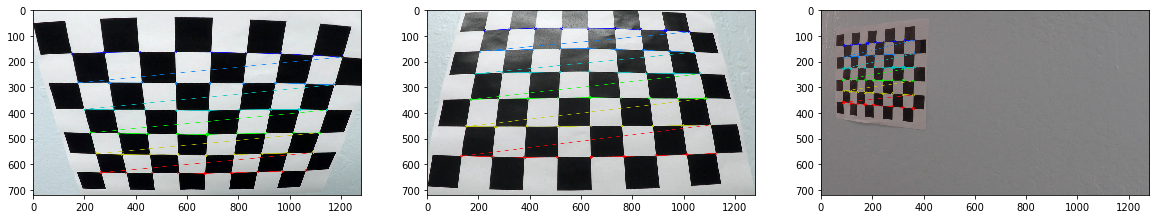

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

%matplotlib inline

nx = 9 #the number of inside corners in x
ny = 6 #the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

camera_dir = 'camera_cal/'

plt.figure(3, figsize=(20,20))
plt_count = 1

for root, dirs, files in os.walk(camera_dir):
    for name in files:
        filepath = os.path.join(root, name)
        img = cv2.imread(filepath)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            
            if plt_count <= 3:
                plt.subplot(1, 3, plt_count)
                plt.imshow(img)
                plt_count += 1

### Distortion correction to raw images

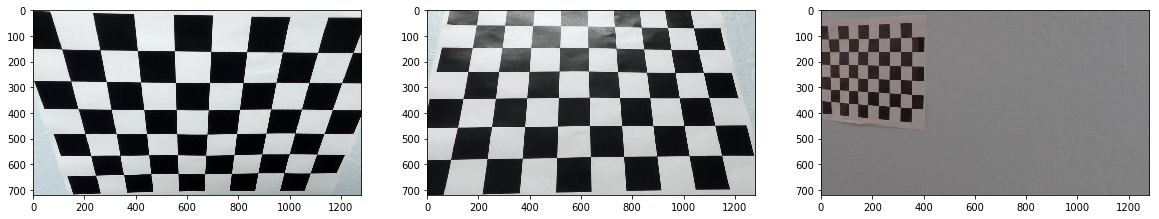

In [2]:
# Use cv2.calibrateCamera() and cv2.undistort()
cal_img = cv2.imread('camera_cal/calibration1.jpg', cv2.IMREAD_GRAYSCALE)
# global parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cal_img.shape[::-1], None, None)

plt.figure(3, figsize=(20,20))
plt_count = 1

for root, dirs, files in os.walk(camera_dir):
    for name in files:
        filepath = os.path.join(root, name)
        img = cv2.imread(filepath)
        
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        if plt_count > 3:
            break
        plt.subplot(1, 3, plt_count)
        plt.imshow(undist_img)
        plt_count += 1

### Create a threshold binary image

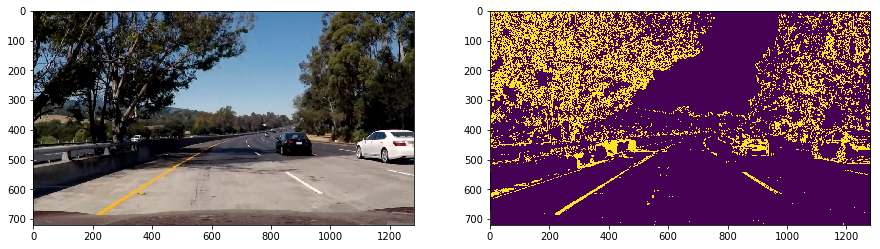

In [3]:
def binary_image(img):
    """convert the original RGB img to a binary img through a seris of thresholds"""
        
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold sobelx
    sobelx_thresh = (20, 100)
    sobelx_binary = np.zeros_like(sobelx)
    sobelx_binary[(scaled_sobelx >= sobelx_thresh[0]) & (scaled_sobelx <= sobelx_thresh[1])] = 1
    
    # Threshold S channel
    s_thresh = (170, 255)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # combine threshold images
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((sobelx_binary == 1)) | (s_binary == 1)] = 1
    
    return combined_binary

test_img = cv2.imread('test_images/test5.jpg')
binary_output = binary_image(test_img)

plt.figure(3, figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(test_img[:,:,::-1])

plt.subplot(1, 2, 2)
plt.imshow(binary_output)

### Perspective Transform

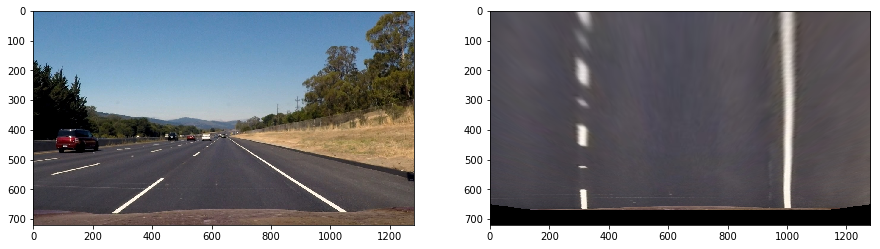

In [4]:
road_img = cv2.imread('test_images/straight_lines2.jpg')

# 4 source coordinates
src = np.float32([[310, 650], [1010, 650], [595, 450], [690, 450]])
# 4 dist coordinates
dst = np.float32([[310, 650], [1010, 650], [310, 100], [1010, 100]])

# perspective transform matrix and its inversion, global parameters
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warp_image(img, mtx, dist, M):
    # undistort the image
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Warp the image
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(undistort_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

warped = warp_image(road_img, mtx, dist, M)

plt.figure(3, figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(road_img[:,:,::-1])

plt.subplot(1, 2, 2)
plt.imshow(warped[:,:,::-1])

### Detect lane pixels and fit to find the lane boundary

(720, 0)

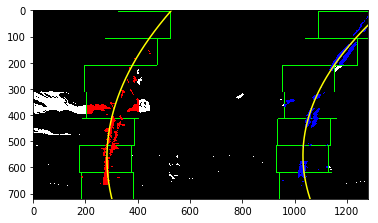

In [5]:
lane_img = cv2.imread('test_images/test5.jpg')

lane_warped = warp_image(lane_img, mtx, dist, M)
binary_warped = binary_image(lane_warped)

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 7
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                     (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Determine the curvature of the lane and vehicle position with respect to center

In [6]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# pixels space
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

# Vehicle position wrt center
diff_center_pix = (leftx_base + rightx_base)/2 - midpoint
diff_center = diff_center_pix * xm_per_pix
if diff_center > 0:
    print('Vehicle is {:.2f}m left of center'.format(diff_center))
else:
    print('Vehicle is {:.2f} right of center'.format(-diff_center))

702.1705896320282 583.0458945972683
212.28692520668136 m 164.74411466257797 m
Vehicle is 0.12m left of center


### Warp the detected lane boundaries back onto the original image

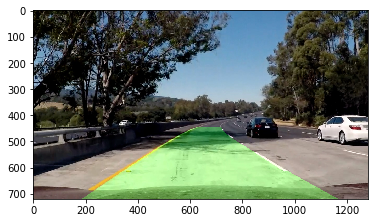

In [7]:
# bird-eyes view
birdeye_img = np.zeros_like(lane_img)
left_fitx_int = np.rint(left_fitx).astype(int)
right_fitx_int = np.rint(right_fitx).astype(int)

# image shape
img_shape = birdeye_img.shape

# Fill the region of lane
for y in range(img_shape[0]):
    for x in range(max(left_fitx_int[y], 0), min(right_fitx_int[y], img_shape[1])):
        birdeye_img[y, x] = [0, 255, 0]
        
# Warp back to the original image
unwarped = cv2.warpPerspective(birdeye_img, Minv, (img_shape[1], img_shape[0]), flags=cv2.INTER_LINEAR)
dst_img = cv2.addWeighted(lane_img, 1.0, unwarped, 0.3, 0)

plt.imshow(dst_img[:,:,::-1])

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

Left curvature = 212.29m Right curvature = 164.74m
Vehicle is 0.12m left of center


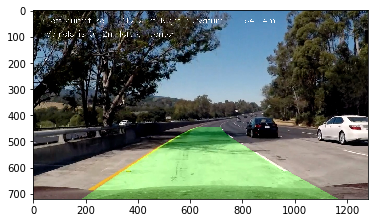

In [8]:
# print text on output image
curve_text = ('Left curvature = {:.2f}m Right curvature = {:.2f}m'.format(left_curverad, right_curverad))

if diff_center > 0:
    center_text = ('Vehicle is {:.2f}m left of center'.format(diff_center))
else:
    center_text = ('Vehicle is {:.2f} right of center'.format(-diff_center))

cv2.putText(dst_img, curve_text, org=(50, 50), fontFace = 0, fontScale = 1, color=(255,255,255))
cv2.putText(dst_img, center_text, org=(50, 100), fontFace = 0, fontScale = 1, color=(255,255,255))
    
plt.imshow(dst_img[:,:,::-1])
print(curve_text)
print(center_text)

### Merge the above 3 steps together to a function

Left curvature = 212.29m Right curvature = 164.74m
Vehicle is 0.12m left of center


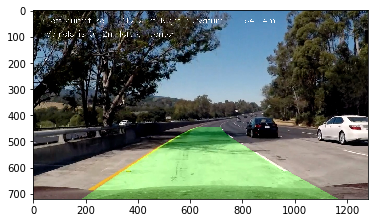

In [9]:
def detect_lane(lane_img):
    lane_warped = warp_image(lane_img, mtx, dist, M)
    binary_warped = binary_image(lane_warped)

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 7
    window_height = np.int(binary_warped.shape[0]//nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                         (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    birdeye_img = np.zeros_like(lane_img)
    left_fitx_int = np.rint(left_fitx).astype(int)
    right_fitx_int = np.rint(right_fitx).astype(int)

    img_shape = birdeye_img.shape

    for y in range(img_shape[0]):
        for x in range(max(left_fitx_int[y], 0), min(right_fitx_int[y], img_shape[1])):
            birdeye_img[y, x] = [0, 255, 0]

    unwarped = cv2.warpPerspective(birdeye_img, Minv, (img_shape[1], img_shape[0]), flags=cv2.INTER_LINEAR)
    dst_img = cv2.addWeighted(lane_img, 1.0, unwarped, 0.3, 0)
    
    curve_text = ('Left curvature = {:.2f}m Right curvature = {:.2f}m'.format(left_curverad, right_curverad))
    
    diff_center_pix = (leftx_base + rightx_base)/2 - midpoint
    diff_center = diff_center_pix * xm_per_pix
    
    if diff_center > 0:
        center_text = ('Vehicle is {:.2f}m left of center'.format(diff_center))
    else:
        center_text = ('Vehicle is {:.2f} right of center'.format(-diff_center))
        
    cv2.putText(dst_img, curve_text, org=(50, 50), fontFace = 0, fontScale = 1, color=(255,255,255))
    cv2.putText(dst_img, center_text, org=(50, 100), fontFace = 0, fontScale = 1, color=(255,255,255))
    
    print(curve_text)
    print(center_text)

    return dst_img

lane_img = cv2.imread('test_images/test5.jpg')
detected_img = detect_lane(lane_img)

plt.imshow(detected_img[:,:,::-1])

### Process video for lane detection

In [ ]:
class Video:
    def __init__(self, first_frame, mtx, dist, M, Minv):
        """ Initialization """
        self.lane_img = first_frame
        self.mtx = mtx
        self.dist = dist
        self.M = M
        self.Minv = Minv
        self.count = 0  # blind dection or not
        
    def warp_img(self):
        # undistort the image
        undistort_img = cv2.undistort(self.lane_img, self.mtx, self.dist, None, self.mtx)
    
        # Warp the image
        img_size = (self.lane_img.shape[1], self.lane_img.shape[0])
        self.warped_img = cv2.warpPerspective(undistort_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    def binarize_img(self):
        # Convert to HLS color space and separate the S channel
        hls = cv2.cvtColor(self.warped_img, cv2.COLOR_BGR2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
    
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold sobelx
        sobelx_thresh = (20, 100)
        sobelx_binary = np.zeros_like(sobelx)
        sobelx_binary[(scaled_sobelx >= sobelx_thresh[0]) & (scaled_sobelx <= sobelx_thresh[1])] = 1
    
        # Threshold S channel
        s_thresh = (170, 220)
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
        # combine threshold images
        combined_binary = np.zeros_like(s_binary)
        combined_binary[(sobelx_binary == 1) | (s_binary == 1)] = 1

        self.binary_warped = combined_binary
    
    def detect_lane_blind(self):
        """ Do a blind search from binary warped image """

        histogram = np.sum(self.binary_warped[self.binary_warped.shape[0]//2:,:], axis=0)

        self.midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:self.midpoint])
        rightx_base = np.argmax(histogram[self.midpoint:]) + self.midpoint

        nwindows = 9
        window_height = np.int(self.binary_warped.shape[0]//nwindows)

        nonzero = self.binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx_current = leftx_base
        rightx_current = rightx_base

        margin = 100
        minpix = 50

        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.binary_warped.shape[0] - (window+1)*window_height
            win_y_high = self.binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                             (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds] 

        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)

    def detect_lane(self):
        """ search in a margin around the previous line position """
        
        nonzero = self.binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
                        self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
                        self.left_fit[1]*nonzeroy + self.left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
                        self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
                        self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
    
    def plot_lane(self):
        """ given poly, plot the lane position on original image """
        
        ploty = np.linspace(0, self.binary_warped.shape[0]-1, self.binary_warped.shape[0])
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        right_curverad = ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])

        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        left_fit_cr = np.polyfit(self.lefty*ym_per_pix, self.leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.righty*ym_per_pix, self.rightx*xm_per_pix, 2)

        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        birdeye_img = np.zeros_like(self.lane_img)
        left_fitx_int = np.rint(left_fitx).astype(int)
        right_fitx_int = np.rint(right_fitx).astype(int)

        img_shape = birdeye_img.shape
        
        for y in range(img_shape[0]):
            for x in range(max(left_fitx_int[y], 0), min(right_fitx_int[y], img_shape[1])):
                birdeye_img[y, x] = [0, 255, 0]

        unwarped = cv2.warpPerspective(birdeye_img, Minv, (img_shape[1], img_shape[0]), flags=cv2.INTER_LINEAR)
        self.dst_img = cv2.addWeighted(self.lane_img, 1.0, unwarped, 0.3, 0)

        curve_text = ('Left curvature = {:.2f}m Right curvature = {:.2f}m'.format(left_curverad, right_curverad))

        leftx_base = self.left_fit[0]*(img_shape[0]-1)**2 + self.left_fit[1]*(img_shape[0]-1) + self.left_fit[2]
        rightx_base = self.right_fit[0]*(img_shape[0]-1)**2 + self.right_fit[1]*(img_shape[0]-1) + self.right_fit[2]
        
        diff_center_pix = (leftx_base + rightx_base)/2 - self.midpoint
        diff_center = diff_center_pix * xm_per_pix
        
        if diff_center > 0:
            center_text = ('Vehicle is {:.2f}m left of center'.format(diff_center))
        else:
            center_text = ('Vehicle is {:.2f} right of center'.format(-diff_center))

        cv2.putText(self.dst_img, curve_text, org=(50, 50), fontFace = 0, fontScale = 1, color=(255,255,255))
        cv2.putText(self.dst_img, center_text, org=(50, 100), fontFace = 0, fontScale = 1, color=(255,255,255))
        
        cv2.imshow('dst_img', self.dst_img)
        cv2.waitKey(1)
        
        return self.dst_img
    
    def functions(self):
        """ Put above functions together """
        self.warp_img()
        self.binarize_img()
        self.detect_lane_blind()
                    
        dst_img = self.plot_lane()
        return dst_img

video_path = 'project_video.mp4'

def animate(video_path):
    cap = cv2.VideoCapture(video_path)
    _, first_frame = cap.read()
    video_obj = Video(first_frame, mtx, dist, M, Minv)
    video_obj.functions()
    
    count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        video_obj.lane_img = frame
        dst_img = video_obj.functions()
        output_dst = 'run/' + str(count) + '.jpg'
        cv2.imwrite(output_dst, dst_img)
        count += 1
                    
    cap.release()
    cv2.destroyAllWindows()

animate(video_path)

### The function outputs images to a folder. Finally I used video.py to convert images to a video file.